In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np

im_W, im_H = 224, 224
datachannel = 3

class_filenames = os.listdir("/content/drive/MyDrive/Dataset/soybeans/train_0")
data_2d = np.empty((len(class_filenames), im_W,im_H, datachannel), dtype="uint8")
label = [0] * len(class_filenames)

In [ ]:
from PIL import Image

for i in range(len(class_filenames)):
    
    if(class_filenames[i][0] == 'g'):
        label[i] = 0
    if(class_filenames[i][0] == 'b'):
        label[i] = 1
    
    img = Image.open("/content/drive/MyDrive/Dataset/soybeans/train_0/" + class_filenames[i])
    img = img.resize((im_W,im_H))
    
    data_2d[i,:,:,:] = np.asarray(img, dtype="uint8")

In [ ]:
from collections import Counter

print("訓練集的特徵維度", data_2d.shape)
print("訓練集類別數量：%s" %Counter(label))

訓練集的特徵維度 (2200, 224, 224, 3)
訓練集類別數量：Counter({1: 1200, 0: 1000})


In [ ]:
from keras.utils import to_categorical

label_ohe = to_categorical(label)
non_data_2d = data_2d.astype('float32')/255

In [ ]:
from keras.applications import ResNet50, ResNet101, VGG16, VGG19, InceptionV3
from keras.layers import Input

#model = ResNet50(include_top=True, weights=None, input_tensor=None, input_shape=None, pooling=None, classes=2)
#model = ResNet101(include_top=True, weights=None, input_tensor=None, input_shape=None, pooling=None, classes=2)
model = InceptionV3(include_top=True, weights=None, input_tensor=Input(shape=(224, 224, 3)), input_shape=None, classes=2)

In [ ]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 111, 111, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 111, 111, 32) 96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 111, 111, 32) 0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

In [ ]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1

    return lr

In [ ]:
from keras.optimizers import Adam

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=lr_schedule(0)), metrics=['accuracy'])

In [ ]:
history = model.fit(x=non_data_2d, y=label_ohe, batch_size=20, epochs=100, validation_split=0.2) 

Epoch 1/100
88/88 [==============================] - 15s 174ms/step - loss: 0.4020 - accuracy: 0.8665 - val_loss: 3.1827 - val_accuracy: 0.5318
Epoch 2/100
88/88 [==============================] - 14s 162ms/step - loss: 0.2332 - accuracy: 0.9108 - val_loss: 4.1317 - val_accuracy: 0.5318
Epoch 3/100
88/88 [==============================] - 14s 163ms/step - loss: 0.2142 - accuracy: 0.9040 - val_loss: 2.1381 - val_accuracy: 0.5318
Epoch 4/100
88/88 [==============================] - 14s 164ms/step - loss: 0.1860 - accuracy: 0.9239 - val_loss: 8.1507 - val_accuracy: 0.5318
Epoch 5/100
88/88 [==============================] - 15s 165ms/step - loss: 0.1738 - accuracy: 0.9335 - val_loss: 2.8205 - val_accuracy: 0.5318
Epoch 6/100
88/88 [==============================] - 15s 166ms/step - loss: 0.1677 - accuracy: 0.9341 - val_loss: 0.4025 - val_accuracy: 0.8705
Epoch 7/100
88/88 [==============================] - 15s 167ms/step - loss: 0.1398 - accuracy: 0.9460 - val_loss: 0.4607 - val_accuracy:

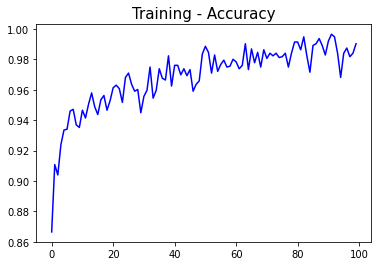

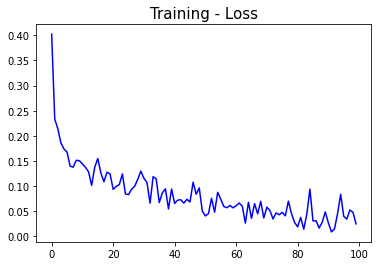

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.title("Training - Accuracy", size='15')
plt.plot(np.arange(len(acc)), acc,color='b')
#plt.plot(np.arange(len(val_acc)), val_acc,color='r', label="Validation set")
#plt.legend(loc='lower right')
#plt.ylim(0, 1.2)
plt.show()

plt.title("Training - Loss", size='15')
plt.plot(np.arange(len(loss)), loss,color='b')
#plt.plot(np.arange(len(val_loss)), val_loss,color='r', label="Validation set")
#plt.legend(loc='upper right')
plt.show()

69/69 [==============================] - 5s 76ms/step - loss: 0.0641 - accuracy: 0.9777
訓練集的準確度為：0.9777
訓練集的損失值為：0.0641


Text(0.5, 1.0, 'Accuracy: 0.9777')

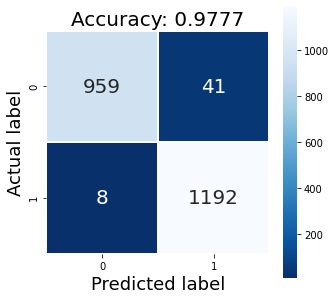

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

train_loss, train_acc = model.evaluate(non_data_2d, label_ohe)
print("訓練集的準確度為：%0.4f" %(train_acc))
print("訓練集的損失值為：%0.4f" %(train_loss))

predict = model.predict(non_data_2d)
predictions = [np.argmax(one_hot)for one_hot in predict]

cm = confusion_matrix(label, predictions)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=1.0, square = True, cmap = 'Blues_r',annot_kws={"size": 20});
plt.ylabel('Actual label', size = 18);
plt.xlabel('Predicted label', size = 18);
plt.title('Accuracy: %0.4f' %(train_acc), size = 20)

In [ ]:
from keras.models import load_model

model.save('soybeans.h5')

from tensorflow.keras.models import load_model

model = load_model('soybeans.h5')

In [ ]:
im_W, im_H = 224, 224
datachannel = 3

v_class_filenames = os.listdir("/content/drive/MyDrive/Dataset/soybeans/valid_0")
v_data_2d = np.empty((len(v_class_filenames), im_W,im_H, datachannel), dtype="uint8")
v_label = [0] * len(v_class_filenames)

for i in range(len(v_class_filenames)):
    
    if(v_class_filenames[i][0] == 'g'):
        v_label[i] = 0
    if(v_class_filenames[i][0] == 'b'):
        v_label[i] = 1
    
    v_img = Image.open("/content/drive/MyDrive/Dataset/soybeans/valid_0/" + v_class_filenames[i])
    v_img = v_img.resize((im_W,im_H))
    
    v_data_2d[i,:,:,:] = np.asarray(v_img, dtype="uint8")

print("驗證集的特徵維度", v_data_2d.shape)
print("驗證集類別數量：%s" %Counter(v_label))

v_label_ohe = to_categorical(v_label)
v_non_data_2d = v_data_2d.astype('float32')/255

驗證集的特徵維度 (1889, 224, 224, 3)
驗證集類別數量：Counter({0: 946, 1: 943})


60/60 [==============================] - 4s 70ms/step - loss: 1.8494 - accuracy: 0.5590
驗證集的準確度為：0.5590
驗證集的損失值為：1.8494


Text(0.5, 1.0, 'Accuracy: 0.5590')

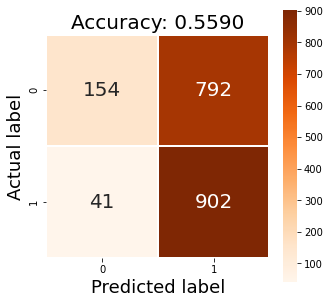

In [ ]:
v_loss, v_acc = model.evaluate(v_non_data_2d, v_label_ohe)
print("驗證集的準確度為：%0.4f" %(v_acc))
print("驗證集的損失值為：%0.4f" %(v_loss))

predict = model.predict(v_non_data_2d)
predictions = [np.argmax(one_hot)for one_hot in predict]

cm = confusion_matrix(v_label, predictions)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=1.0, square = True, cmap = 'Oranges',annot_kws={"size": 20});
plt.ylabel('Actual label', size = 18);
plt.xlabel('Predicted label', size = 18);
plt.title('Accuracy: %0.4f' %(v_acc), size = 20)

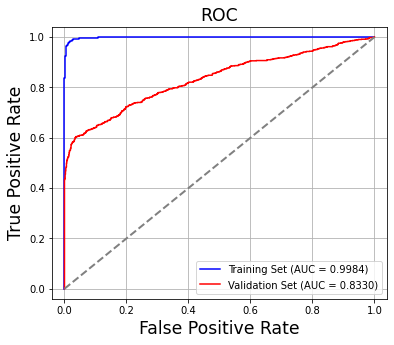

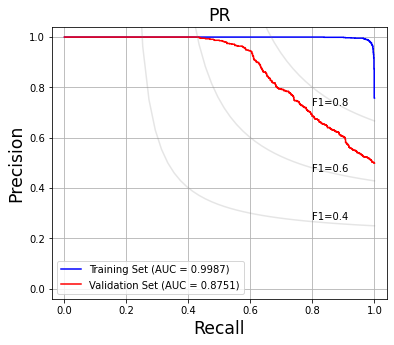

In [ ]:
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve

#pyplot.style.use("ggplot")

t_predict = model.predict(non_data_2d)
v_predict = model.predict(v_non_data_2d)

# ROC
pyplot.figure(figsize=(6,5))

fpr, tpr, thresholds = roc_curve(y_true=label, y_score=t_predict[:,1]) 
roc_auc = auc(x=fpr, y=tpr)
pyplot.plot(fpr,tpr,color='b',label='%s (AUC = %0.4f)' % ('Training Set', roc_auc))

fpr, tpr, thresholds = roc_curve(y_true=v_label, y_score=v_predict[:,1]) 
roc_auc = auc(x=fpr, y=tpr)
pyplot.plot(fpr,tpr,color='r',label='%s (AUC = %0.4f)' % ('Validation Set', roc_auc))

pyplot.legend(loc='lower right')
pyplot.title("ROC" ,size ='xx-large')
pyplot.plot([0, 1],[0, 1],linestyle='--',color='gray',linewidth=2,)
pyplot.xlim([-0.04, 1.04])
pyplot.ylim([-0.04, 1.04])
pyplot.grid()
pyplot.xlabel('False Positive Rate',size ='xx-large')
pyplot.ylabel('True Positive Rate',size ='xx-large')
pyplot.show()

# PR
pyplot.figure(figsize=(6,5))

precision, recall, thresholds = precision_recall_curve(label, t_predict[:,1]) 
pr_auc = auc(x=recall, y=precision)
pyplot.plot(recall,precision,color='b',label='%s (AUC = %0.4f)' % ('Training Set', pr_auc))

precision, recall, thresholds = precision_recall_curve(v_label, v_predict[:,1]) 
pr_auc = auc(x=recall, y=precision)
pyplot.plot(recall,precision,color='r',label='%s (AUC = %0.4f)' % ('Validation Set', pr_auc))

pyplot.legend(loc='lower left')
f_scores = np.linspace(0.4, 0.8, num=3)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = pyplot.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    pyplot.annotate('F1={0:0.1f}'.format(f_score), xy=(0.8, y[45] + 0.02)) 
    
pyplot.title("PR",size ='xx-large')
pyplot.xlim([-0.04, 1.04])
pyplot.ylim([-0.04, 1.04])
pyplot.grid()
pyplot.xlabel('Recall',size ='xx-large')
pyplot.ylabel('Precision',size ='xx-large')
pyplot.show()

In [ ]:
def TrainVerificationReturn(y_train, y_pred, Th):
    __, __, thresholds = roc_curve(y_true=y_train, y_score=y_pred)     
      
    TN = 0; FN = 0; FP = 0; TP = 0
    for i in range(0,len(y_pred),1):  
        if(y_pred[i] < Th):  
            if(y_train[i] == 0):
                TN = TN + 1
            else:
                FN = FN + 1
        else:
            if(y_train[i] == 1):
                TP = TP + 1
            else:
                FP = FP + 1
    
    if((FN+TP)!=0):
        Sen = TP/(FN+TP)
    else:
        Sen = 0
    
    if((TN+FP)!=0):
        Spe = TN/(TN+FP)
    else:
        Spe = 0
        
    if((TP+FP)!=0):
        Pre = TP/(TP+FP)
    else:
        Pre = 0
        
    if((Pre+Sen)!=0):    
        F1 = 2*Pre*Sen/(Pre+Sen)
    else:
        F1 = 0
    
    Acc = (TN+TP)/(TN+TP+FP+FN)
    
    return TN, FN, TP, FP, Sen, Spe, Pre, F1, Acc

In [ ]:
import pandas as pd

#計算每個切點的驗證
__, __, thresholds = roc_curve(y_true=label, y_score=t_predict[:,1]) 
TNList, FNList, TPList, FPList, SenList, SpeList, PreList, F1List, AccList = [],[],[],[],[],[],[],[],[]
for i in range(0,len(thresholds),1):
    TN, FN, TP, FP, Sen, Spe, Pre, F1, Acc = TrainVerificationReturn(label, t_predict[:,1], thresholds[i])
    TNList.append(TN)
    FNList.append(FN)
    TPList.append(TP)
    FPList.append(FP)
    SenList.append(Sen)
    SpeList.append(Spe)
    PreList.append(Pre)
    F1List.append(F1)
    AccList.append(Acc)
    
ThresholdsList = thresholds.tolist()

excel = pd.DataFrame(ThresholdsList,columns=['Thresholds'])
excel['TN'] = pd.Series(TNList, index=excel.index)
excel['FN'] = pd.Series(FNList, index=excel.index)
excel['TP'] = pd.Series(TPList, index=excel.index)
excel['FP'] = pd.Series(FPList, index=excel.index)
excel['Sen'] = pd.Series(SenList, index=excel.index)
excel['Spe'] = pd.Series(SpeList, index=excel.index)
excel['Pre'] = pd.Series(PreList, index=excel.index)
excel['F1'] = pd.Series(F1List, index=excel.index)
excel['Acc'] = pd.Series(AccList, index=excel.index)

excel.to_csv('Result_Training.csv')

#計算每個切點的驗證
__, __, thresholds = roc_curve(y_true=v_label, y_score=v_predict[:,1]) 
TNList, FNList, TPList, FPList, SenList, SpeList, PreList, F1List, AccList = [],[],[],[],[],[],[],[],[]
for i in range(0,len(thresholds),1):
    TN, FN, TP, FP, Sen, Spe, Pre, F1, Acc = TrainVerificationReturn(v_label, v_predict[:,1], thresholds[i])
    TNList.append(TN)
    FNList.append(FN)
    TPList.append(TP)
    FPList.append(FP)
    SenList.append(Sen)
    SpeList.append(Spe)
    PreList.append(Pre)
    F1List.append(F1)
    AccList.append(Acc)
    
ThresholdsList = thresholds.tolist()

excel = pd.DataFrame(ThresholdsList,columns=['Thresholds'])
excel['TN'] = pd.Series(TNList, index=excel.index)
excel['FN'] = pd.Series(FNList, index=excel.index)
excel['TP'] = pd.Series(TPList, index=excel.index)
excel['FP'] = pd.Series(FPList, index=excel.index)
excel['Sen'] = pd.Series(SenList, index=excel.index)
excel['Spe'] = pd.Series(SpeList, index=excel.index)
excel['Pre'] = pd.Series(PreList, index=excel.index)
excel['F1'] = pd.Series(F1List, index=excel.index)
excel['Acc'] = pd.Series(AccList, index=excel.index)

excel.to_csv('Result_Validation.csv')